## Analog and digital signals

Analog signals are in essence signals which exist in the real world as physical quantities, those can be electrical current, sound or temperature. A important characteristic of these signals is that they're continuous, which means for any moment in time, there exists an amplitude of the signal associated with that moment.

Digital signals on the other hand exist in discrete quantities, that is, they can only assume a finite number of states and be associated to a finite number of moments in time. There are many reasons for wanting to represent an analog quantity an a discrete manner, such as easier processing, enconding, transmission or storage. Reciprocally, digital signals are easy to work with, but except for purely numerical aplications, aren't much useful until they're converted back into analog quantities. 

The analog to digital conversion (A/D) can be modeled by the steps of sampling, quantization and sampled to discrete conversion. The digital to analog conversion (D/A) is modeled by the step of reconstuction. Both A/D and D/A will be discussed through this notebook.

Since this notebook runs on a digital device, it's not possible to perfectly represent a continuous time signal. For that reason, this notebook will represent continuous time signals as large arrays with an associated "time-axis" and "time slice". The first array will represent the amplitudes of the signal over time, the second one is a representation of the window in time during which we we'll be observing the signal, Finally, the "time slice" is a scalar relating the integer array-indexes we have in discrete time to moments in continuous time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sampling_lib import plot_impulses, sampled_to_discrete, rect
from scipy.signal import unit_impulse

## Sampling stage

where $x(kTs)$ is the impulse area in $x_s(t)$, which coincides with the amplitude of $x(t)$ at
$t = kTs$. The amplitude of $x_s(t)$ is not defined when $t = kTs$ and zero otherwise. The
notation $x^a_s (t)$ will sometimes be used to emphasize we mean the area of the impulse at
time $t$.

The goal here is to represent an analog signal $x(t)$ with samples taken at a regular interval (known as the sampling interval). For example, telephony adopts a sampling frequency $Fs = 8000Hz$, which means the sampling interval $Ts = 125 \mu s$

Periodic sampling can be modeled as the multiplication of $x(t)$
by a periodic impulse train $p(t)$. The snippet below generates and depicts the impulse train
for sampling at $8 kHz$. As conventionally done, the impulses heights indicate their
areas. The sampled signal is denoted as
$$x_s(t) = x(t)p(t) = \sum_{k=-\infty}^{\infty} x(kTs)\delta(t - kTs)$$


/home/eduardofilho/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


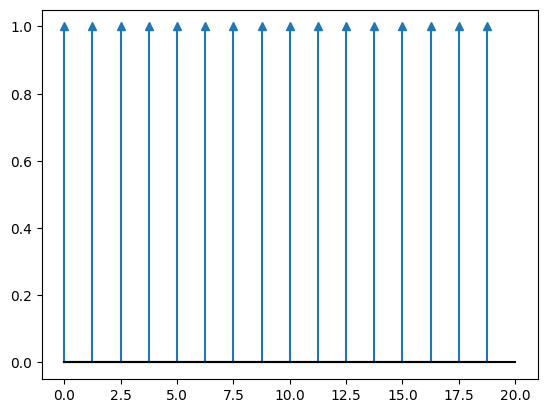

In [2]:
# Generate a time windows representing 2 ms and calculate the associated time slice
time_axis = np.linspace(0,20,10000)
time_slice = 20/10000

# Initalize an array to hold our impulse train
impulse_train = np.zeros_like(time_axis)

# Determine the "sampling period" for our impulses, so that they have 125us in distance
discrete_Ts = int((125e-6/1e-4)*(1/time_slice))

# Populate the impulse train p(t)
for i in range(len(impulse_train)):
    if i % discrete_Ts == 0:
        impulse_train += unit_impulse(shape = impulse_train.shape, idx = i)
        
plot_impulses(time_axis,impulse_train)


## Example of periodic sampling

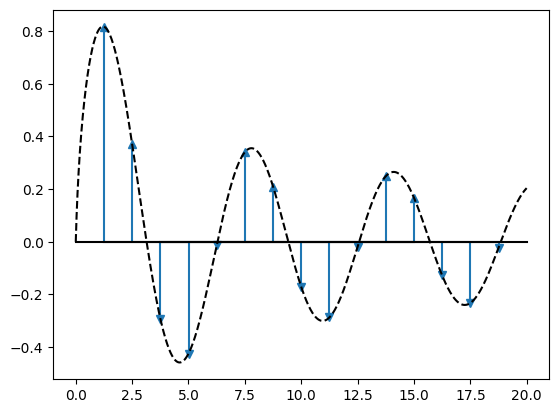

In [3]:
# Generate our signal to study
x_original = np.sin(time_axis)/np.sqrt(time_axis + 0.1)

# Multiply by our impulse train
x_sampled = x_original*impulse_train

# This plots the sampled signal
plot_impulses(time_axis,x_sampled)

# This plots the envelope
plt.plot(time_axis,x_original, "k--")


In terms of computational cost, it is often convenient to use the smallest possible
value of $Fs$. But choosing $Fs$ too small may lead to a sampled signal that does not
represent well the original signal. The Shannon-Nyquist sampling theorem states that in order to perfectly reconstruct a signal, the sampling frequency must be greater than twice the highest frequency component in the signal.
$$F_s > 2F_{\text{max}}$$

## Sampled to discrete conversion

After a signal is sampled, its still represented by continuous time unit impulses and though discrete, may still have real numbers on it's time-axis. The sampled to discrete (S/D) conversion represents the transition from continuous time impulses to discrete time impulses, and is always associated with a sampling period $Ts$. For example, if 
$$x_s(t) = 3\delta(t + 2T_s) - \delta(t + T_s) + 8\delta(t) - 5\delta(t - 3T_s) $$
The sampled to discrete conversion outputs
$$x[n] = 3\delta[n + 2] - \delta[n + 1] + 8\delta[n] - 5\delta[n - 3]$$
It's important to note that now $x[n]$ can be interpreted as an array, as it has only integer indexes and it's entries represent amplitudes.

<StemContainer object of 3 artists>

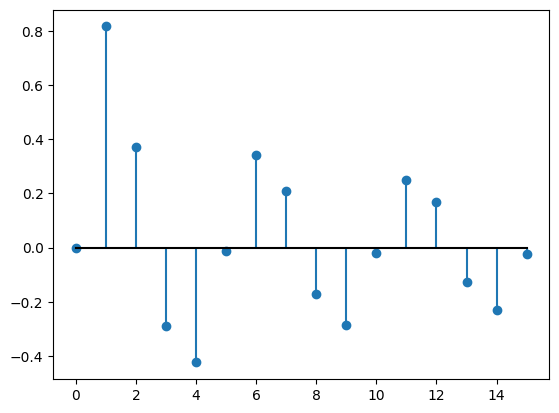

In [4]:
x_discrete = sampled_to_discrete(x_sampled,discrete_Ts)
plt.stem(x_discrete, basefmt="k-")


# Reconstruction

In the context of A/D and D/A processes, the sampling inverse operation is called
reconstruction, and converts a sampled signal $x_s(t)$ into an analog signal $x(t)$. Reconstruction is also called interpolation or filtering. It consists of choosing a function $h(t)$
that is combined with $x_s(t)$ as follows:
$$x(t) = \sum_{n=-\infty}^{\infty} x_a[nT_s]h(t - nT_s)$$

Because $x_s(t)$ is obtained from $x[n]$ via a D/S process, it is convenient to rewrite this equation observing that the impulse area $xa
s (nTs)$ coincides with its corresponding
amplitude $x[n]$, such that:
$$x(t) = \sum_{n=-\infty}^{\infty} x[n]h(t - nT_s)$$

Among many alternatives for choosing the reconstruction function $h(t)$, two important
ones are the so-called zero-order holder (ZOH) $h(t) = \Pi((t − 0.5Ts)/Ts)$ and sinc
reconstruction $h(t) = sinc(t/Ts)$. ZOH is useful for its simplicity, while sincs achieve a
perfect reconstruction. They are discussed in the next topics.

## Example: Reconstruction with ZOH

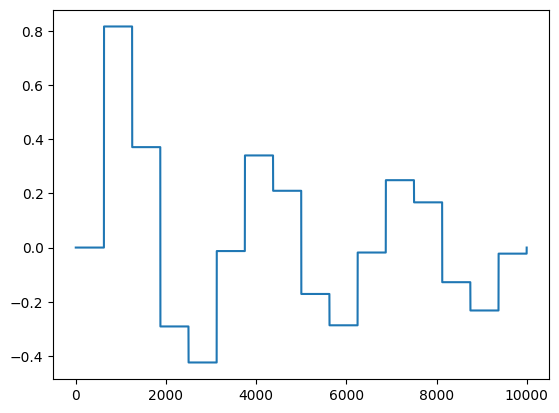

In [5]:
x_ZOH_reconstructed = np.zeros_like(time_axis)

Ts = time_slice*(len(x_original)/len(x_discrete))


for i in range(len(x_discrete)):
    x_ZOH_reconstructed += x_discrete[i]*rect((time_axis-i*Ts - 0.5*Ts)/Ts)

plt.plot(x_ZOH_reconstructed)

The reconstructed signal does properly interpolate all of the entries of the discrete time signal.
However, notice that the output is "pointy" and does not look entirely alike to the original one. This can be made more evident by plotting the original and the reconstructed signal side by side

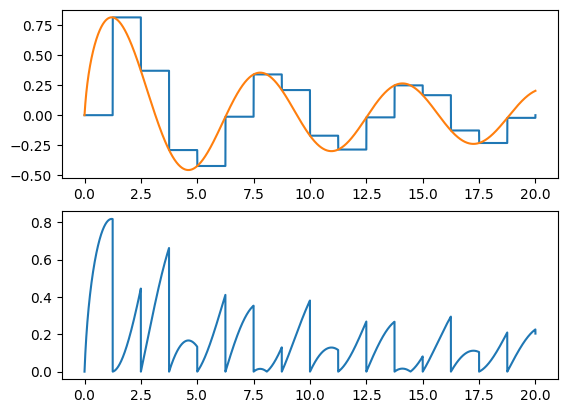

In [8]:
plt.subplot(211)
plt.plot(time_axis,x_ZOH_reconstructed)
plt.plot(time_axis,x_original)
plt.subplot(212)
plt.plot(time_axis, abs(x_ZOH_reconstructed-x_original))

In fourrier analysis, whenever a signal contains sudden changes in amplitude, such as spikes or ponty edges, it's said that it contains high-frequency components. With this ideia in mind, we can state the previously noted fact in a more mathematical language, the ZOH-reconstructed signal has more high-frequency components than the original signal. Understanding this the question arises. Is there a form of reconstruction which does not add high frequencies to the reconstructed signal?

# Example : Reconstuction with sincs

Presumably, the answer to the previous question is affirmative and the $sinc$ function is the one employed for such...

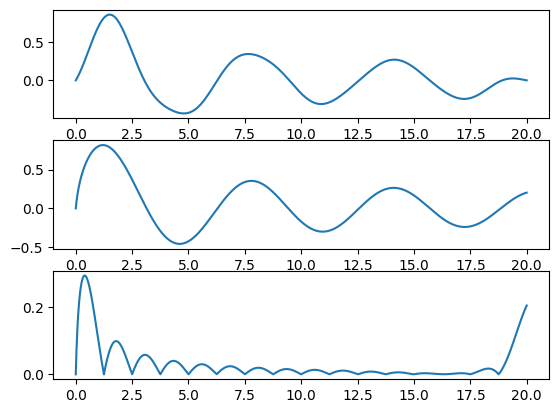

In [6]:
x_sinc_reconstructed = np.zeros_like(time_axis)

for i in range(len(x_discrete)):
    x_sinc_reconstructed += x_discrete[i]*np.sinc((time_axis-i*Ts)/Ts)

plt.subplot(311)
plt.plot(time_axis,x_sinc_reconstructed)
plt.subplot(312)
plt.plot(time_axis,x_original)
plt.subplot(313)
plt.plot(time_axis, abs(x_sinc_reconstructed-x_original))


Now a contradiction becomes clear. $sinc$ reconstruction was supposed to be perfect, but we find a non-zero error...non-infinite number of samples, quantization could be mentioned as well